In [19]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Sequential
from keras.callbacks import LearningRateScheduler
from keras.src.layers import Flatten, Dense
from keras.src.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [4]:
X_train_full.dtype

dtype('uint8')

* Podzielmy pełny zestaw treningowy na zestaw walidacyjny i zestaw treningowy. 
* Kolor pikseli skalujemy również do zakresu 0-1 i przekształcamy na zmiennoprzecinkowe, dzieląc przez 255.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

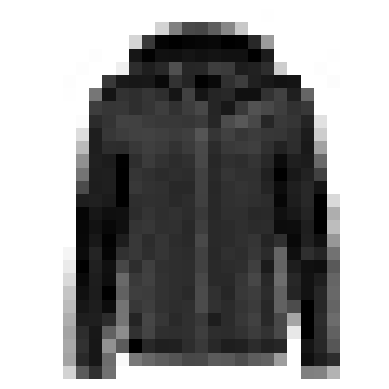

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [7]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Będziemy używać klas numerycznych i nazw.

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Coat'

Możemy narysować więcej przykładów treningowych.

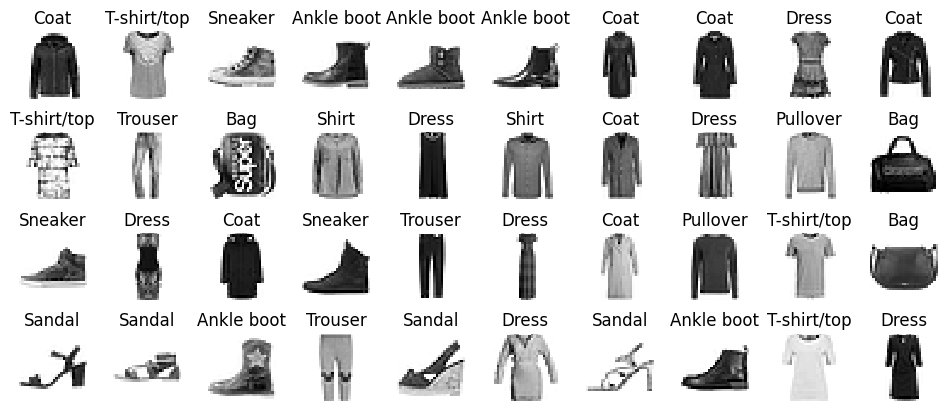

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

In [11]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lrate

In [12]:
optimizer_configs = [
    {"name": "Adam 0.001", "learning_rate": 0.001, "use_scheduler": False},
    {"name": "Adam 0.001 with scheduler", "learning_rate": 0.001, "use_scheduler": True},
    {"name": "Adam 0.0001 with scheduler", "learning_rate": 0.0001, "use_scheduler": True},
]

In [13]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [16]:
models_history_name = []

for config in optimizer_configs:
    optimizer = keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))  # Flatten images
    model.add(Dense(300, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    callbacks = []
    if config["use_scheduler"]:
        callbacks.append(LearningRateScheduler(step_decay))
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=32, epochs=30,
                        verbose=0, callbacks=callbacks)
    models_history_name.append((history, model, config["name"]))
    print(f"finished {config['name']}")

finished Adam 0.001
finished Adam 0.001 with scheduler
finished Adam 0.0001 with scheduler


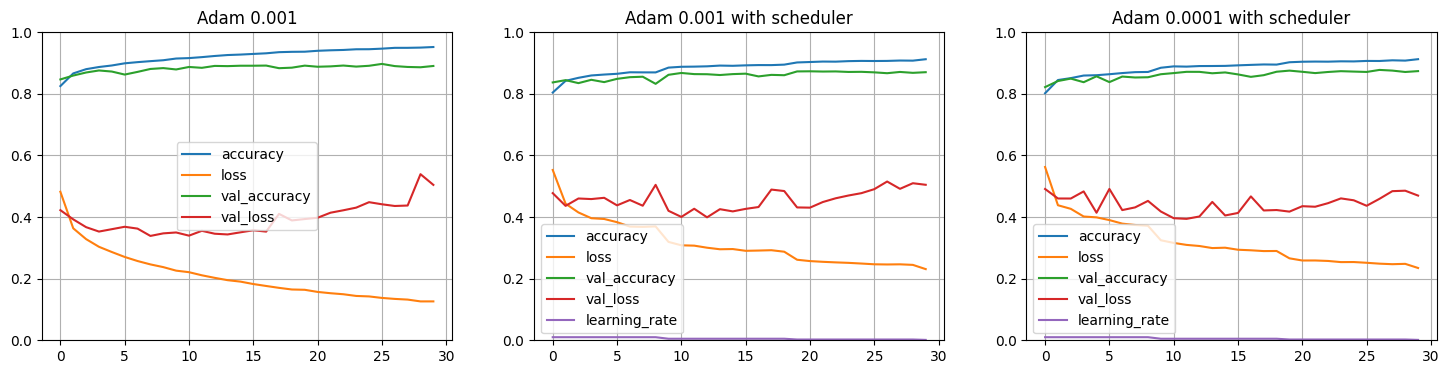

In [17]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))

axs = axs.flatten()

for i, (history, model, name) in enumerate(models_history_name):
    pd.DataFrame(history.history).plot(ax=axs[i])
    axs[i].set_title(name)
    axs[i].set_ylim(0, 1)
    axs[i].grid(True)
    axs[i].legend()

In [20]:
df = pd.DataFrame(columns=["config", "accuracy"])

for i, (history, model, name) in enumerate(models_history_name):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    df.loc[i] = [name, accuracy]

df

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


,config,accuracy
0,Adam 0.001,0.8906
1,Adam 0.001 with scheduler,0.8704
2,Adam 0.0001 with scheduler,0.8739


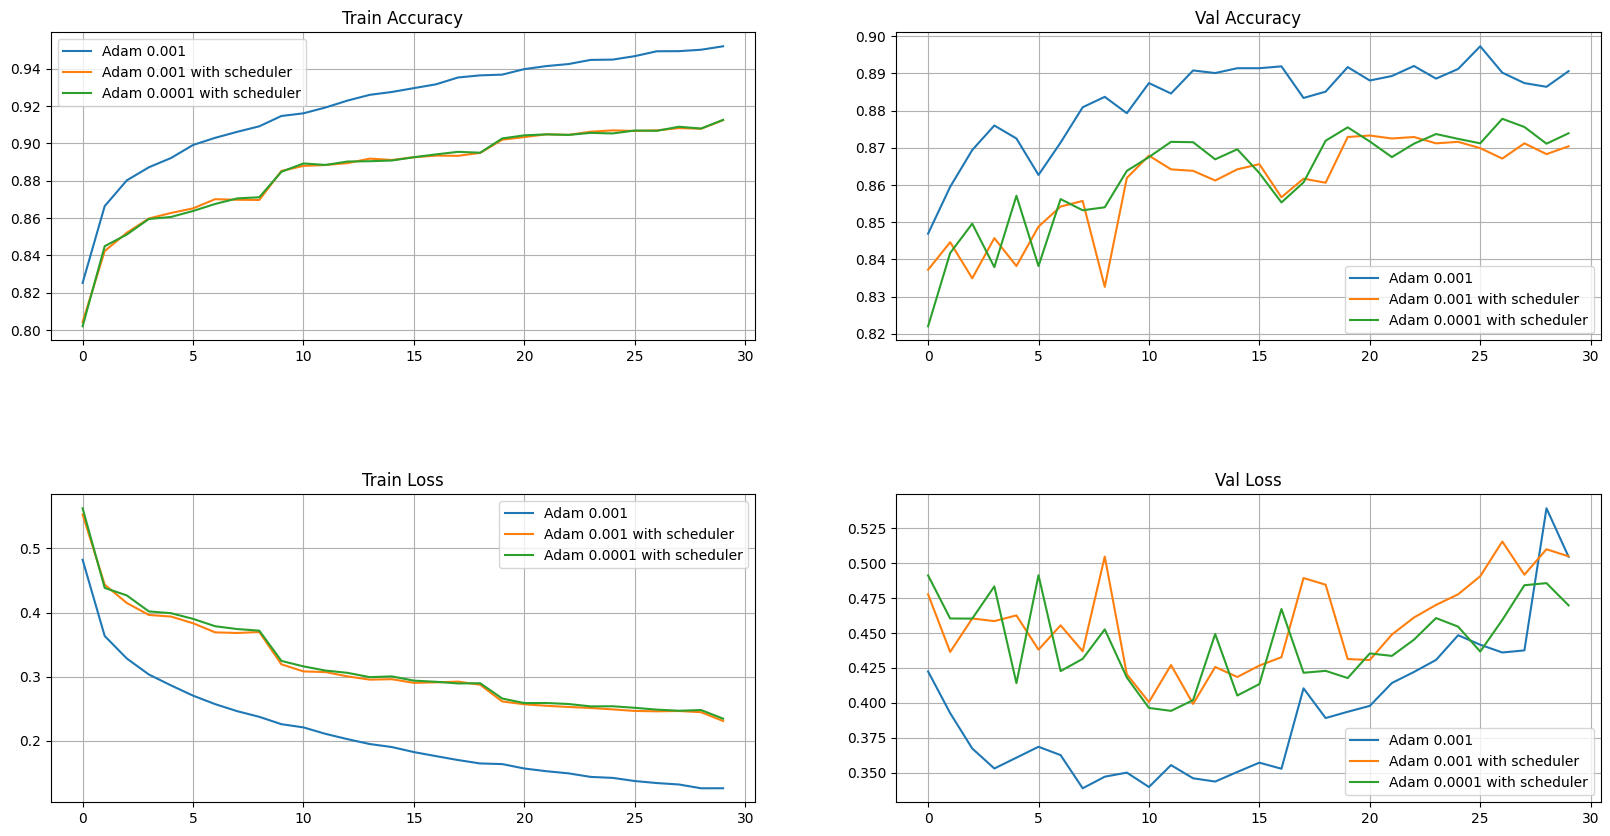

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, (history, _, name) in enumerate(models_history_name):
    axs[0][0].plot(history.history['accuracy'], label=f'{name}')
    axs[0][1].plot(history.history['val_accuracy'], label=f'{name}')
    axs[1][0].plot(history.history['loss'], label=f'{name}')
    axs[1][1].plot(history.history['val_loss'], label=f'{name}')

axs[0][0].set_title('Train Accuracy')
axs[0][1].set_title('Val Accuracy')
axs[1][0].set_title('Train Loss')
axs[1][1].set_title('Val Loss')

for ax in axs.flatten():
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()